# Demo parameter sweeps of channel measurements
This demonstrates the construction of larger datasets built by looping across measurements of different channels.

In [1]:
from edge_analyzer import channel_waveform
from edge_analyzer.io import simulated_awgn
import xarray as xr

sample_rate_Hz = 15.36e6
analysis_bandwidth_Hz = 10e6

analysis_spec = {
    'power_time_series': {
        'detector_period': 10e-3,
        'detectors': ('rms', 'peak')
    },
    'cyclic_channel_power': {
        'cyclic_period': 10e-3,
        'detector_period': 1e-3 / 15 / 4,
        'detectors': ('rms', 'peak'),
        'cyclic_statistics': ('min', 'mean', 'max'),
    },
    'persistence_spectrum': {
        'window': 'flattop',
        'resolution': 15e3,
        'quantiles': [0.1, 0.25, 0.5, 0.75, 0.9, 0.95, 0.99, 0.999, 1],
    },
    'amplitude_probability_distribution': {
        'power_low': -40,
        'power_high': 15,
        'power_count': 221,  # 0.25 dB resolution
    },
    'iq_waveform': {
        'start_time_sec': 0,
        'stop_time_sec': 100e-3
    }
}

filter_spec = {
    'ola': {
        'fft_size': 1024,
        'window': 'hamming',  # 'hamming', 'blackman', or 'blackmanharris'
    },
}

acquisition_spec = {
    'duration': 0.2,
    'sample_rate': sample_rate_Hz
}

### Single acquisition

In [2]:
iq = simulated_awgn(
    **acquisition_spec, power=sample_rate_Hz / analysis_bandwidth_Hz
)

channel_waveform.from_spec(
    iq,
    sample_rate_Hz,
    analysis_bandwidth_Hz=analysis_bandwidth_Hz,
    filter_spec=filter_spec,
    analysis_spec=analysis_spec,
)

(6001, 1024)


<xarray.Dataset> Size: 25MB
Dimensions:                             (persistence_statistic: 9,
                                         baseband_frequency: 667,
                                         power_detector: 2,
                                         cyclic_statistic: 3, cyclic_lag: 600,
                                         time_elapsed: 20, channel_power: 221,
                                         iq_sample: 1536000)
Coordinates:
  * persistence_statistic               (persistence_statistic) <U5 180B '0.1...
  * baseband_frequency                  (baseband_frequency) float64 5kB -4.9...
  * power_detector                      (power_detector) <U4 32B 'rms' 'peak'
  * cyclic_statistic                    (cyclic_statistic) <U4 48B 'min' ... ...
  * cyclic_lag                          (cyclic_lag) float64 5kB 0.0 ... 0.00...
  * time_elapsed                        (time_elapsed) float64 160B 0.0 ... 0.19
  * channel_power                       (channel_power) float64 2kB -40.0 ......
  * iq_sample                           (iq_sample) int64 12MB 0 1 ... 1535999
Data variables:
    persistence_spectrum                (persistence_statistic, baseband_frequency) float64 48kB ...
    cyclic_channel_power                (power_detector, cyclic_statistic, cyclic_lag) float64 29kB ...
    power_time_series                   (power_detector, time_elapsed) float64 320B ...
    amplitude_probability_distribution  (channel_power) float64 2kB 0.9999 .....
    iq_waveform                         (iq_sample) complex64 12MB (-0.460988...
Attributes:
    sample_rate_Hz:         15360000.0
    analysis_bandwidth_Hz:  10000000.0
    filter:                 {'ola': {'fft_size': 1024, 'window': 'hamming'}}

## RF parameter sweep
### Single parameter

In [3]:
data = []

for fc in [3705e6, 3715e6, 3725e6]:
    iq = simulated_awgn(
        **acquisition_spec, power=sample_rate_Hz / analysis_bandwidth_Hz
    )

    ret = channel_waveform.from_spec(
        iq,
        sample_rate_Hz,
        analysis_bandwidth_Hz=analysis_bandwidth_Hz,
        filter_spec=filter_spec,
        analysis_spec=analysis_spec,
    )

    data.append(ret.assign_coords({'center_frequency': [fc]}))

data = xr.combine_by_coords(data)
data

(6001, 1024)
(6001, 1024)
(6001, 1024)


<xarray.Dataset> Size: 49MB
Dimensions:                             (persistence_statistic: 9,
                                         baseband_frequency: 667,
                                         center_frequency: 3,
                                         power_detector: 2,
                                         cyclic_statistic: 3, cyclic_lag: 600,
                                         time_elapsed: 20, channel_power: 221,
                                         iq_sample: 1536000)
Coordinates:
  * persistence_statistic               (persistence_statistic) <U5 180B '0.1...
  * baseband_frequency                  (baseband_frequency) float64 5kB -4.9...
  * power_detector                      (power_detector) <U4 32B 'rms' 'peak'
  * cyclic_statistic                    (cyclic_statistic) <U4 48B 'min' ... ...
  * cyclic_lag                          (cyclic_lag) float64 5kB 0.0 ... 0.00...
  * time_elapsed                        (time_elapsed) float64 160B 0.0 ... 0.19
  * channel_power                       (channel_power) float64 2kB -40.0 ......
  * iq_sample                           (iq_sample) int64 12MB 0 1 ... 1535999
  * center_frequency                    (center_frequency) float64 24B 3.705e...
Data variables:
    persistence_spectrum                (center_frequency, persistence_statistic, baseband_frequency) float64 144kB ...
    cyclic_channel_power                (center_frequency, power_detector, cyclic_statistic, cyclic_lag) float64 86kB ...
    power_time_series                   (center_frequency, power_detector, time_elapsed) float64 960B ...
    amplitude_probability_distribution  (center_frequency, channel_power) float64 5kB ...
    iq_waveform                         (center_frequency, iq_sample) complex64 37MB ...
Attributes:
    sample_rate_Hz:         15360000.0
    analysis_bandwidth_Hz:  10000000.0
    filter:                 {'ola': {'fft_size': 1024, 'window': 'hamming'}}

In [4]:
data = []

for atten in [0, 10]:
    for fc in [3705e6, 3715e6, 3725e6]:
        iq = simulated_awgn(
            **acquisition_spec, power=sample_rate_Hz / analysis_bandwidth_Hz
        )

        ret = channel_waveform.from_spec(
            iq,
            sample_rate_Hz,
            analysis_bandwidth_Hz=analysis_bandwidth_Hz,
            filter_spec=filter_spec,
            analysis_spec=analysis_spec,
        )

        data.append(ret.assign_coords({'center_frequency': [fc], 'attenuation': [atten]}))

dataset = xr.combine_by_coords(data)
dataset.center_frequency.attrs = {'label': 'RF center frequency', 'units': 'Hz'}
dataset.attenuation.attrs = {'label': 'External attenuation setting', 'units': 'dB'}

# dataset.chunk({'iq_sample': int(dataset.attrs['sample_rate_Hz']*10e-3)}).to_zarr('dataset.zarr', mode='w')

dataset

(6001, 1024)
(6001, 1024)
(6001, 1024)
(6001, 1024)
(6001, 1024)
(6001, 1024)


<xarray.Dataset> Size: 87MB
Dimensions:                             (persistence_statistic: 9,
                                         baseband_frequency: 667,
                                         attenuation: 2, center_frequency: 3,
                                         power_detector: 2,
                                         cyclic_statistic: 3, cyclic_lag: 600,
                                         time_elapsed: 20, channel_power: 221,
                                         iq_sample: 1536000)
Coordinates:
  * persistence_statistic               (persistence_statistic) <U5 180B '0.1...
  * baseband_frequency                  (baseband_frequency) float64 5kB -4.9...
  * power_detector                      (power_detector) <U4 32B 'rms' 'peak'
  * cyclic_statistic                    (cyclic_statistic) <U4 48B 'min' ... ...
  * cyclic_lag                          (cyclic_lag) float64 5kB 0.0 ... 0.00...
  * time_elapsed                        (time_elapsed) float64 160B 0.0 ... 0.19
  * channel_power                       (channel_power) float64 2kB -40.0 ......
  * iq_sample                           (iq_sample) int64 12MB 0 1 ... 1535999
  * center_frequency                    (center_frequency) float64 24B 3.705e...
  * attenuation                         (attenuation) int64 16B 0 10
Data variables:
    persistence_spectrum                (attenuation, center_frequency, persistence_statistic, baseband_frequency) float64 288kB ...
    cyclic_channel_power                (attenuation, center_frequency, power_detector, cyclic_statistic, cyclic_lag) float64 173kB ...
    power_time_series                   (attenuation, center_frequency, power_detector, time_elapsed) float64 2kB ...
    amplitude_probability_distribution  (attenuation, center_frequency, channel_power) float64 11kB ...
    iq_waveform                         (attenuation, center_frequency, iq_sample) complex64 74MB ...
Attributes:
    sample_rate_Hz:         15360000.0
    analysis_bandwidth_Hz:  10000000.0
    filter:                 {'ola': {'fft_size': 1024, 'window': 'hamming'}}

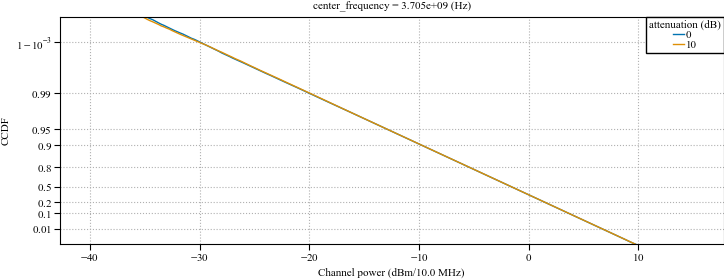

In [5]:
import iqwaveform
from edge_analyzer import figures
import matplotlib.pyplot as plt
plt.style.use('iqwaveform.ieee_double_column')

fig, ax = plt.subplots()
apd = dataset.amplitude_probability_distribution.sel(center_frequency=3705e6)
apd.plot.line(x='channel_power', ax=ax)
ax.set_yscale('gamma-qq', k=1, db_ordinal=True)
figures.label_axis(ax.xaxis, apd, 'channel_power', tick_units=False)
figures.label_axis(ax.yaxis, apd)

<xarray.DataArray 'iq_waveform' (attenuation: 2, center_frequency: 3,
                                 iq_sample: 1536000)> Size: 74MB
array([[[-1.3927644 +0.21058527j, -0.6451011 +0.77624077j,
          0.36379343+0.747047j  , ...,  0.29810518-0.13468397j,
          0.13484693+1.0592874j , -0.6636153 +0.843108j  ],
        [-0.7530394 -1.3019104j ,  0.17488654+0.3765832j ,
          0.81906134+1.1041154j , ...,  0.7490397 -0.4641503j ,
          0.13264355-1.7423466j , -0.5712215 +0.32628167j],
        [-0.38886243-0.17980288j,  0.71585697-0.6627294j ,
          0.6226716 -0.16701107j, ...,  0.87367004+1.604731j  ,
          0.711297  +0.8990549j , -0.42084497-0.4640126j ]],

       [[-0.7142876 +1.0839454j , -0.10147154-0.14046733j,
         -0.4567847 -1.0590415j , ...,  0.6023127 +0.27583334j,
         -0.29102603-0.15076207j, -1.1328412 +0.1388175j ],
        [-0.05344473-0.70708436j, -1.0871906 +0.14535655j,
         -0.17085533+0.06012874j, ..., -0.25351623+0.4470466j ,
         -0.8938045 -0.1405032j , -0.43097687-0.05620606j],
        [-0.12363955+0.43761092j, -0.44451794-0.9056826j ,
          0.42039886-1.8264326j , ..., -0.5994923 +0.6723491j ,
         -0.15980057+0.36975032j,  0.05493917+0.06717912j]]],
      dtype=complex64)
Coordinates:
  * iq_sample         (iq_sample) int64 12MB 0 1 2 3 ... 1535997 1535998 1535999
  * center_frequency  (center_frequency) float64 24B 3.705e+09 ... 3.725e+09
  * attenuation       (attenuation) int64 16B 0 10

In [30]:
# ds['iq_waveform'] = (ds.iq_waveform.dims, ds.iq_waveform.values.view('float32').astype('float16'))


ValueError: conflicting sizes for dimension 'iq_sample': length 3072000 on 'iq_waveform' and length 1536000 on {'persistence_statistic': 'persistence_statistic', 'baseband_frequency': 'baseband_frequency', 'attenuation': 'persistence_spectrum', 'center_frequency': 'persistence_spectrum', 'power_detector': 'power_detector', 'cyclic_statistic': 'cyclic_statistic', 'cyclic_lag': 'cyclic_lag', 'time_elapsed': 'time_elapsed', 'channel_power': 'channel_power', 'iq_sample': 'iq_sample'}

In [25]:
import xarray as xr
ds.iq_waveform.real.combine_first(ds.iq_waveform.imag)

xr.concat([ds.iq_waveform.real, ds.iq_waveform.imag], dim=[''])

Object `ds.iq_waveform.combine` not found.


In [90]:
import zarr
from pathlib import Path
import numpy as np

def directory_size(path):
    path = Path(path)
    if path.is_file():
        return path.stat().st_size
    
    children = Path(path).glob('**/*')
    return sum([p.stat().st_size for p in children if p.is_file()])

ds = dataset.copy()
del ds['iq_waveform']
ds['iq_waveform'] = (dataset['iq_waveform'].dims[:-1] + ('waveform_index',), dataset['iq_waveform'].values.view('float32').astype('float16'))


# assume we will want to read 10 ms at a time for performance reasons
path = 'xarray-sweep.zarr'
compressor = zarr.Blosc(cname="zstd", clevel=3, shuffle=2)
chunks = {'iq_sample': int(ds.attrs['sample_rate_Hz']*10e-3)}
# store = zarr.ZipStore(path, mode='w')
%timeit -n1 -r1 ds.chunk(chunks).to_zarr(path, encoding={"iq_waveform": {"compressor": compressor}}, mode='w')

print(f'total size: {directory_size(path)/1e6:0.1f} MB')

168 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
total size: 33.3 MB


/var/folders/4c/2cryg6ld5b10g45f5cpsrf740016fl/T/ipykernel_40146/3543556192.py:2: RuntimeWarning: overflow encountered in cast
  uint = in_.astype(np.float16).view(np.uint16)


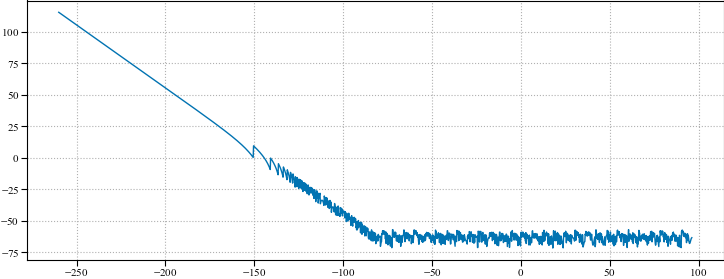

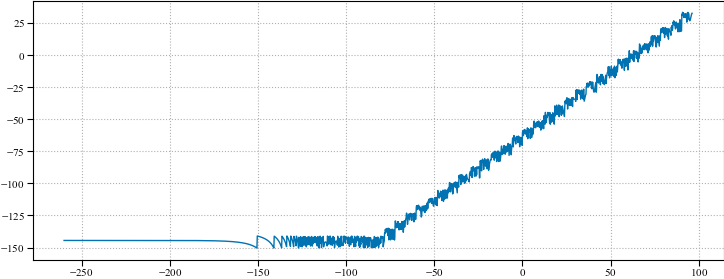

In [120]:
in_ = (np.logspace(-13,13,26*100+1,dtype=np.float64))
uint = in_.astype(np.float16).view(np.uint16)
rounding_err = (uint+np.uint16(1)).view(np.float16).astype(np.float64) - in_
plt.plot(20*np.log10(in_), 20*np.log10(rounding_err/in_))

fig, ax = plt.subplots()
plt.plot(20*np.log10(in_), 20*np.log10(rounding_err))

array([1.e-13, 1.e-12, 1.e-11, 1.e-10, 1.e-09, 1.e-08, 1.e-07, 1.e-06,
       1.e-05, 1.e-04, 1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02,
       1.e+03, 1.e+04, 1.e+05, 1.e+06, 1.e+07, 1.e+08, 1.e+09, 1.e+10,
       1.e+11, 1.e+12, 1.e+13])

In [85]:
ds['iq_waveform'].values.shape

(2, 3, 3072000)

In [67]:
ds = dataset.copy()
del ds['iq_waveform']
ds